# Model with Official Data (Marta's upload) & Incorporating Dummies by Regionname below

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('OFFICIAL_cleaned_data_without_outliers.csv')
pd.DataFrame(data)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,118.675000,1970.0,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.000000,1900.0,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.000000,1900.0,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,98.886364,2016.0,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.000000,2014.0,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13143,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,200.896591,1981.0,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13144,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.000000,1995.0,-37.85927,144.87904,Western Metropolitan,6380.0
13145,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,163.000000,1997.0,-37.85274,144.88738,Western Metropolitan,6380.0
13146,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.000000,1920.0,-37.85908,144.89299,Western Metropolitan,6380.0


In [4]:
#Missing values
missing_per_column = data.isnull().sum()
missing_per_column

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

In [7]:
#Defining variables and splitting the dataset
#Features and target variable
X = data[['Rooms','Bathroom','Distance','Landsize']].values
y = np.log(data['Price'])

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [8]:
#Standardizing predictors
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#Adding intercept to column X
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (10518, 5)
Shape of X_test (with intercept): (2630, 5)


In [10]:
#Predictive model
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=10)) #Mean=0, Var=10^2

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=2,scale=1)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

In [11]:
#MCMC Algorithm
def metropolis_hastings(y,X, iterations=1000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.1,size=n_params)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.1)
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

    return np.array(beta_samples), np.array(sigma2_samples)

In [12]:
#Running the model
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations=5000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)
print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_64191/2704323511.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)


Posterior Mean of coefficients: [13.09765057  0.22682477  0.16999323 -0.29845878  0.19209551]
Posterior Mean of Variance: 0.8852393504973359


In [13]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [14]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (2630, 5)
beta_mean shape: (5,)
Shape of X_train: (10518, 5)


In [15]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 547616.0282908363
Mean Squared Error: 538206216558.5102


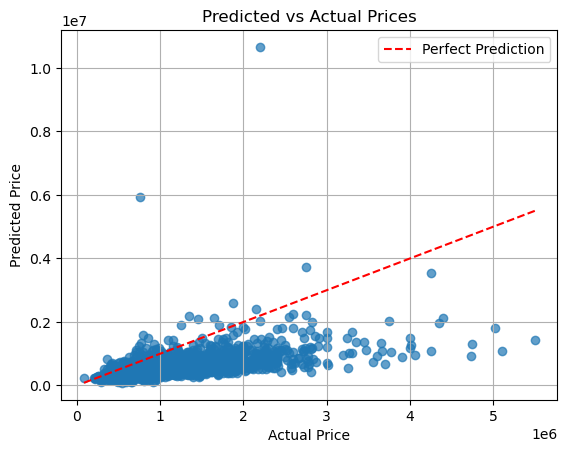

In [23]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()

# Tweaking the model --> adding predictors

### Creating dummies for each region (except 1 ofc)

In [24]:
#Checking how many unique region names there are
print(data['Regionname'].unique())

['Northern Metropolitan' 'Western Metropolitan' 'Southern Metropolitan'
 'Eastern Metropolitan' 'South-Eastern Metropolitan' 'Eastern Victoria'
 'Northern Victoria' 'Western Victoria']


In [26]:
#Creating dummies for each Region
data_encoded = pd.get_dummies(data, columns=['Regionname'],drop_first=True)
print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Suburb                                 13148 non-null  object 
 1   Address                                13148 non-null  object 
 2   Rooms                                  13148 non-null  int64  
 3   Type                                   13148 non-null  object 
 4   Price                                  13148 non-null  float64
 5   Method                                 13148 non-null  object 
 6   SellerG                                13148 non-null  object 
 7   Date                                   13148 non-null  object 
 8   Distance                               13148 non-null  float64
 9   Postcode                               13148 non-null  float64
 10  Bedroom2                               13148 non-null  float64
 11  Ba

Eastern Metropolitan is the left out dummy.

In [29]:
#Defining variables and splitting the dataset
#Features and target variable
X = data_encoded[['Rooms','Bathroom','Distance','Landsize','Regionname_Eastern Victoria',
          'Regionname_Northern Metropolitan','Regionname_Northern Victoria',
          'Regionname_South-Eastern Metropolitan','Regionname_Southern Metropolitan',
          'Regionname_Western Metropolitan','Regionname_Western Victoria']].values
y = np.log(data_encoded['Price'])

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [31]:
#Checking X
print("Shape of X:", X.shape)
print("First row of X:", X[0])

Shape of X: (13148, 11)
First row of X: [2 1.0 2.5 202.0 False True False False False False False]


In [44]:
#Fixing data type
X_test = X_test.astype(float)
X_train = X_train.astype(float)

In [45]:
#Standardizing predictors
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
#Adding intercept to column X
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (10518, 12)
Shape of X_test (with intercept): (2630, 12)


In [47]:
#Predictive model
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=10)) #Mean=0, Var=10^2

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=2,scale=1)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

In [48]:
#MCMC Algorithm
def metropolis_hastings(y,X, iterations=1000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.1,size=n_params)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.1)
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

    return np.array(beta_samples), np.array(sigma2_samples)

In [49]:
#Running the model
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations=5000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)
print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_64191/2704323511.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)


Posterior Mean of coefficients: [ 1.31084022e+01  2.34274677e-01  1.25670738e-01 -2.51649718e-01
  1.79942749e-01  1.85829672e-02 -5.00467390e-03 -2.50412431e-02
  5.81316067e-02  6.92938603e-02 -1.15337635e-01 -5.02091778e-02]
Posterior Mean of Variance: 1.1569384430182923


In [50]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [51]:
print("y_test dtype:", y_test.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("X_train dtype:", X_train.dtype)

y_test dtype: float64
X_test dtype: float64
y_train dtype: float64
X_train dtype: float64


In [52]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (2630, 12)
beta_mean shape: (12,)
Shape of X_train: (10518, 12)


In [53]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 540438.7349693114
Mean Squared Error: 497282795977.9299


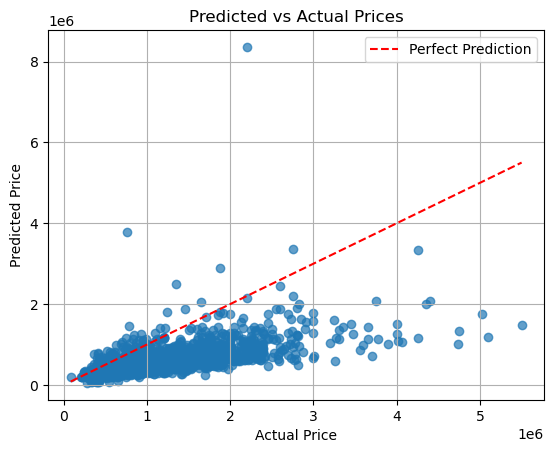

In [54]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()